In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates,
    MAMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.trainer.multioutput import TrainerEnsemble
from src.backend.Logger import Logger


In [3]:
from enum import Enum
UncertaintyMethod = Enum('UncertaintyMethod', 'pred_var MI pred_entropy KL pred_entropy_single')
uncertaintyMethod = "pred_entropy"
# uncertaintyMethod = "pred_var"
# uncertaintyMethod = "MI"
# uncertaintyMethod = "KL"

# uncertaintyMethod = "pred_entropy_single"


In [4]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [5]:

config = {
	"training": False,
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 10,
	"removePolygons": True,
	"uncertainty_method": uncertaintyMethod
}
print(config)

'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''


# dates = [2020, 2021]
# dataset = MAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	
# site = 'MT'
site = 'PA'

if site == 'PA':
	dates = [2018, 2019]

	dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
	# dataset.prodes_dates = [2018, 2019, 2020]

elif site == 'MT':
	dates = [2019, 2020]

	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
	# dataset.prodes_dates = [2019, 2020, 2021]


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = config['inference_times']


if config['training'] == False:

	if type(dataset) == PAMultipleDates:
		# exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122] # same date
		exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121] # earlier date

	if type(dataset) == MTMultipleDates:
		# exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117] # same date
		exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123] # earlier date

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140

logger = Logger()
trainer = TrainerEnsemble(config, dataset, patchesHandler, logger)

trainer.defineExperiment(exp_ids)


{'training': False, 'save_probabilities': False, 'loadInference': False, 'addPastDeforestationInput': True, 'inference_times': 10, 'removePolygons': True, 'uncertainty_method': 'pred_entropy'}


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp_ids

[123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121]

In [7]:
trainer.classes_mode

False

In [8]:
# trainer.setExperimentPath()
# trainer.createLogFolders()

In [9]:
# ic(type(dataset), exp, dataset.dates)


In [10]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [11]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [12]:

trainer.label_mask.dtype

dtype('uint8')

In [13]:
unique, count = np.unique(trainer.label_mask, return_counts=True)
print(unique, count)

total = np.sum(count)
percentage_count = [round(x*100, 1) for x in count / total]
print(percentage_count)

[0 1 2] [100903598   1838508  60373894]
[61.9, 1.1, 37.0]


In [14]:
# pdb.set_trace()

In [15]:

trainer.getLabelCurrentDeforestation()

In [16]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [17]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

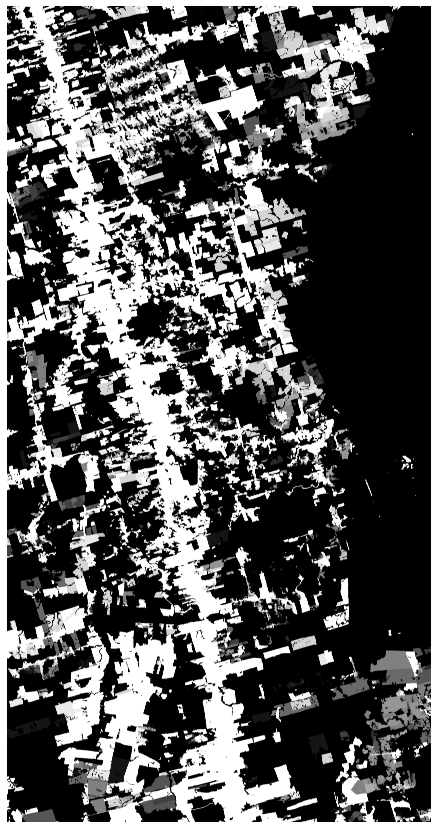

In [18]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [19]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [20]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [21]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


In [22]:
if config["training"] == True:
    trainer.extractCoords()

In [23]:
if config["training"] == True:
    trainer.trainTestSplit()

In [24]:
if config["training"] == True:
    trainer.label_mask.shape

In [25]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [26]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [27]:
if config["training"] == True:
    print(trainer.coords_train)

In [28]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

In [29]:
if config["training"] == True:
    inputSnipShow = True

In [30]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [31]:
'''
count, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [32]:
'''
count, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [33]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


In [34]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


In [35]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

In [36]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [37]:
if config["training"] == True:
    trainer.getGenerators()


In [38]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [39]:
if config["training"] == True:
    print(trainer.path_exp)

In [40]:
if config["training"] == True:
    print(trainer.channels)

In [41]:
if config["training"] == True:
    print(trainer.image_stack.shape)

In [42]:
if config["training"] == True:
    trainer.train()

In [43]:
if config["training"] == True:
    trainer.plotHistory()


In [44]:
trainer.image_stack.shape

(17730, 9200, 21)

In [45]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [46]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]


In [47]:
trainer.image_stack.shape

(17730, 9200, 21)

In [48]:
trainer.setPadding()

-30.0 -16.0


In [49]:
trainer.infer()

time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [50]:
trainer.loadPredictedProbabilities()

In [51]:
trainer.prob_rec.shape

(17760, 9216, 10)

In [52]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [53]:
trainer.prob_rec.shape

(17760, 9216, 10)

In [54]:
trainer.getMeanProb()


In [55]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 1.4644367e-15
    np.mean(value): 0.012334157
    np.max(value): 0.9999992


In [56]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

In [57]:
trainer.unpadMeanProb()

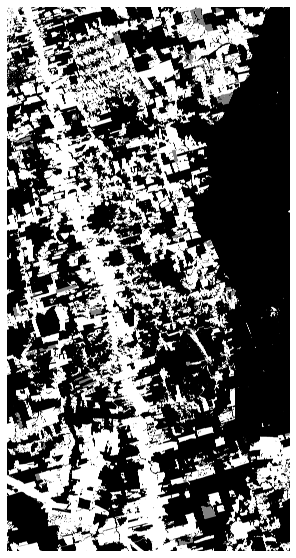

In [58]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [59]:
trainer.squeezeLabel()

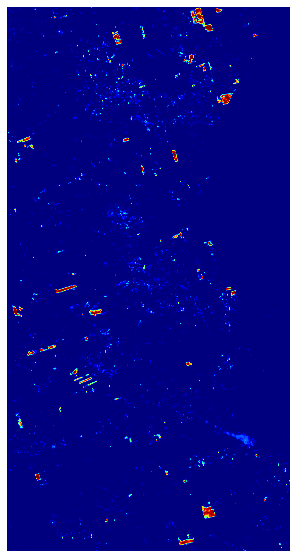

In [60]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [61]:
print(trainer.label_mask.shape)

(17730, 9200)


In [62]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [63]:
# trainer.getMAP()

In [64]:
trainer.prob_rec.shape

(17760, 9216, 10)

In [65]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(10, 17760, 9216, 1)


In [66]:
trainer.prob_rec.shape

(10, 17760, 9216, 1)

In [67]:
trainer.logger.getStats(trainer.prob_rec)

ic| np.min(value): 0.0
    np.mean(value): 0.012330051
    np.max(value): 1.0


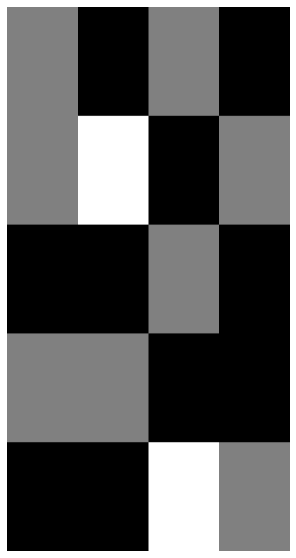

In [68]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [69]:
trainer.getLabelCurrentDeforestation()

In [70]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161675361,   1440639], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [71]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [72]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161675361,   1440639], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161789622,   1326378], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([163001739,    114261], dtype=int64))


In [73]:
trainer.calculateMetrics()

ic| self.f1: 81.41, self.precision: 97.07, self.recall: 70.1


In [74]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9439113,)
ic| f1_val: 82.77
    precision_val: 89.56
    recall_val: 76.94
    mAP_val: 85.73


In [75]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [76]:
trainer.get_label_no_buffer()


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


In [77]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162427946,    688054], dtype=int64))


In [78]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


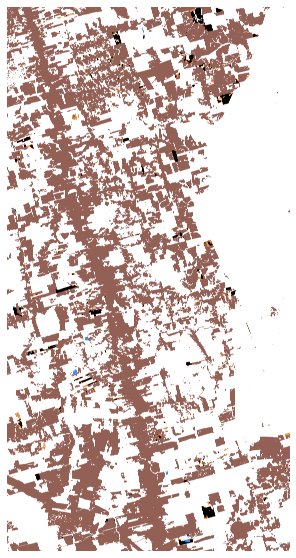

In [79]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [80]:
'''
import types

trainer.setUncertainty = types.MethodType(setUncertainty, trainer)
'''


'\nimport types\n\ntrainer.setUncertainty = types.MethodType(setUncertainty, trainer)\n'

In [81]:
trainer.prob_rec.shape

(10, 17760, 9216, 1)

In [82]:
trainer.setUncertainty()

In [83]:
trainer.uncertainty_map.shape

(17760, 9216)

In [84]:
trainer.logger.getStats(trainer.uncertainty_map)

ic| np.min(value): 4.9258988e-14
    np.mean(value): 0.010970183
    np.max(value): 0.36787948


In [85]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0
    np.mean(value): 0.009594776
    np.max(value): 0.36787948


ic| trainer.uncertainty_to_show.shape: (17730, 9200)


(17730, 9200)

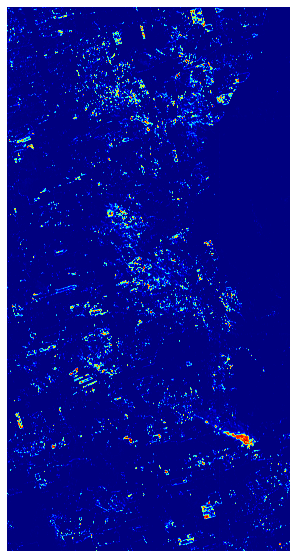

In [86]:

trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty '+trainer.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(trainer.uncertainty_to_show.shape)



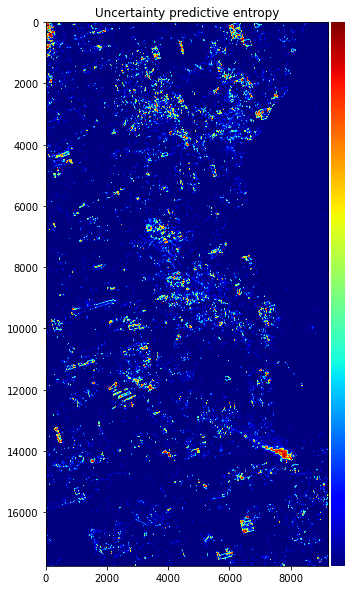

In [87]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(trainer.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + trainer.title_name + ' uncertainty '+trainer.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

In [88]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54181542,)


ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


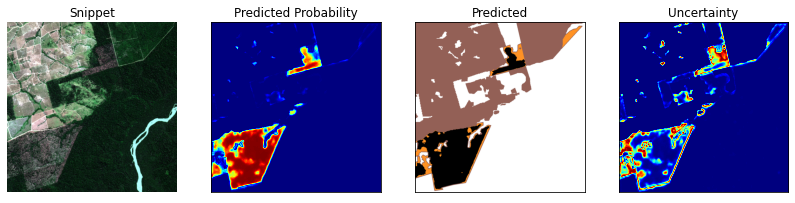

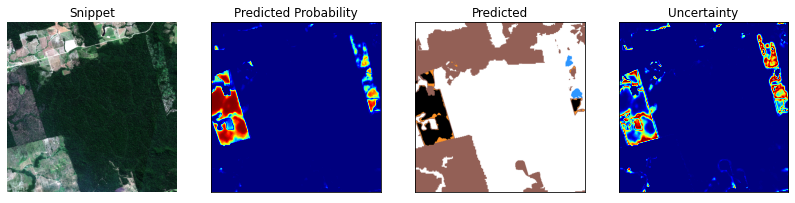

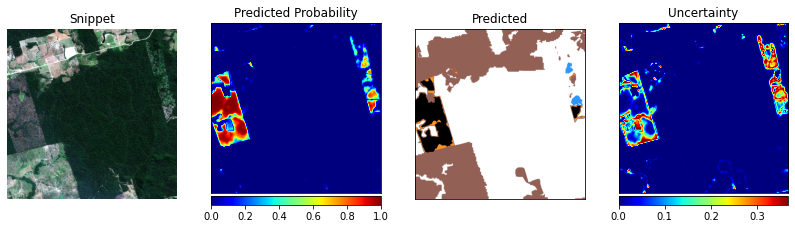

In [89]:
trainer.logger.plotCropSample(trainer)

In [90]:

label_tmp_dates = []
for date in dataset.prodes_dates:
    label_tmp_date = dataset.loadLabelFromDate(date)
    label_tmp_date = label_tmp_date[:trainer.mask_tiles.shape[0], :trainer.mask_tiles.shape[1]]
    label_tmp_dates.append(label_tmp_date)

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


In [91]:
np.unique(label_tmp_dates[0], return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([104050616,   2209014,  56856370], dtype=int64))

In [92]:
label_tmp_dates[0].shape

(17730, 9200)

In [93]:
# del trainer.image_stack
import src.lansdatLoader as ll
import importlib
importlib.reload(ll)
landsatLoader = ll.LandsatLoader(dataset)
ims = landsatLoader.load()
for idx in range(len(ims)):
    ims[idx] = ims[idx][:trainer.mask_tiles.shape[0], :trainer.mask_tiles.shape[1],:]
ims = landsatLoader.darken_past_deforestation(ims, trainer.label_no_buffer)
ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

Loading D:/Jorge/datasets/landsat/PA/landsat_PA_2018.tif
D:/Jorge/datasets/landsat/PA/landsat_PA_2018.tif
Loading D:/Jorge/datasets/landsat/PA/landsat_PA_2019.tif
D:/Jorge/datasets/landsat/PA/landsat_PA_2019.tif
Loading D:/Jorge/datasets/landsat/PA/landsat_PA_2020.tif
D:/Jorge/datasets/landsat/PA/landsat_PA_2020.tif


In [94]:
np.unique(label_tmp_dates[0], return_counts=True)

(array([0, 1], dtype=uint8), array([160906986,   2209014], dtype=int64))

In [95]:
ims[0].shape

(17730, 9200, 3)

In [96]:
trainer.classes_mode

False

In [97]:
'''
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
fig.set_figheight(20)
fig.set_figwidth(20)
lims = trainer.dataset.previewLims1
axes[0].imshow(ims[0][lims[0]:lims[1], lims[2]:lims[3]], cmap=plt.cm.gray)
'''

'\nfig, axes = plt.subplots(2, 3)\naxes = axes.flatten()\nfig.set_figheight(20)\nfig.set_figwidth(20)\nlims = trainer.dataset.previewLims1\naxes[0].imshow(ims[0][lims[0]:lims[1], lims[2]:lims[3]], cmap=plt.cm.gray)\n'

In [98]:
# trainer.dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

In [119]:
import src.backend.Logger as lg 
importlib.reload(lg)
logger = lg.Logger()


ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))


[(17730, 9200, 3), (17730, 9200, 3), (17730, 9200, 3), (17730, 9200), (17730, 9200, 3), (17730, 9200)]
(1000, 1000, 3)
(1000, 1000, 3)
(1000, 1000, 3)


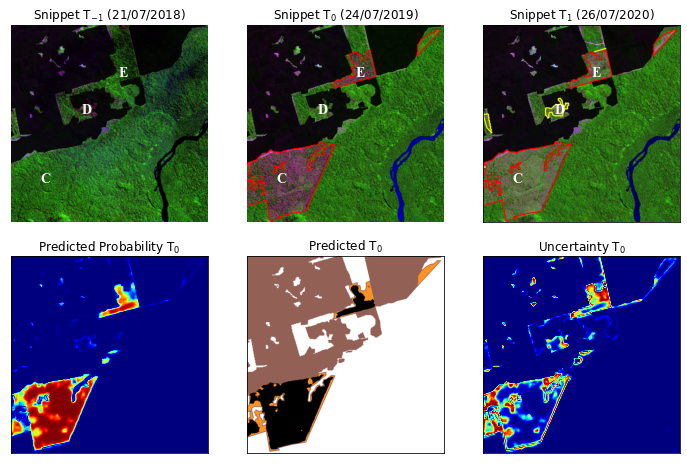

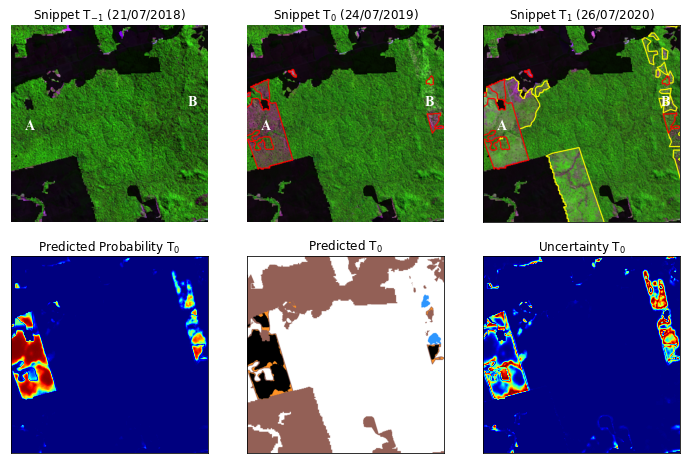

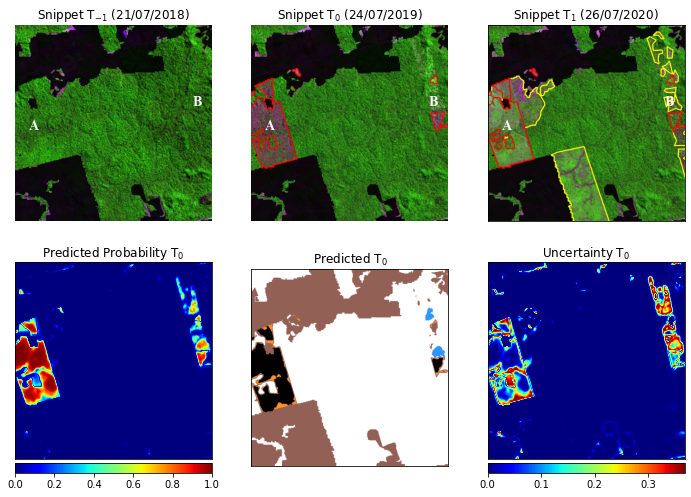

In [120]:
logger.plotCropSampleLandsat(trainer, ims)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


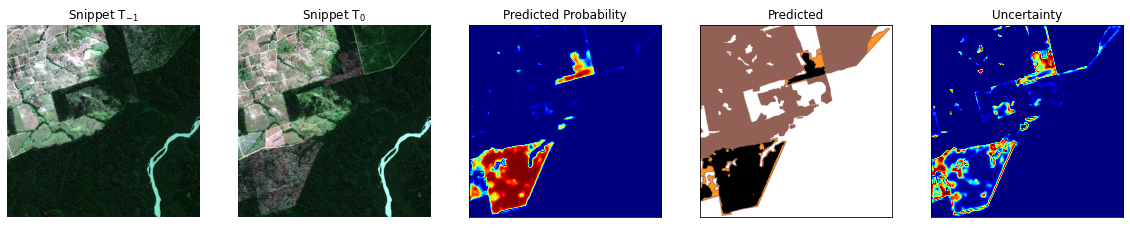

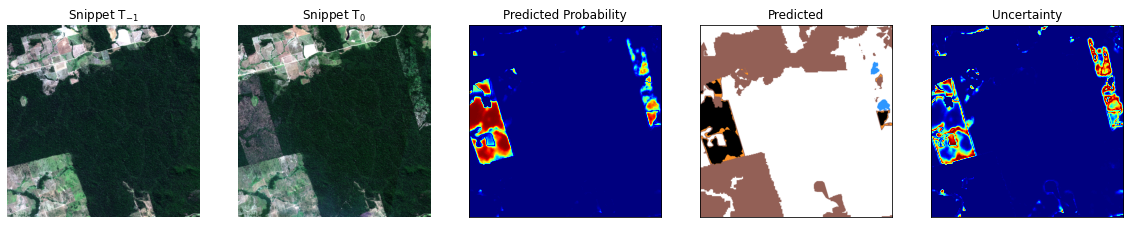

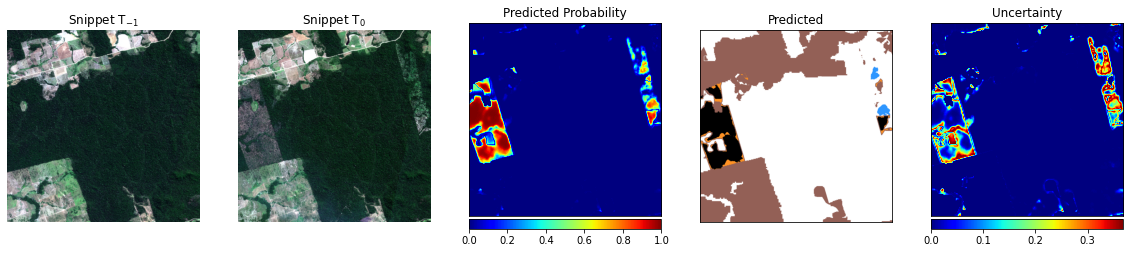

In [102]:
logger.plotCropSampleT0T1(trainer)

In [103]:
'''
dataset.previewLims1 = np.array([200, 700, 10200, 11200])
dataset.previewLims2 = np.array([2500, 3500, 6000, 7000])
'''

'\ndataset.previewLims1 = np.array([200, 700, 10200, 11200])\ndataset.previewLims2 = np.array([2500, 3500, 6000, 7000])\n'

In [104]:
'''
import importlib
importlib.reload(_plt)
plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        importlib.reload(_plt)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1_.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2_.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Snippet $\mathregular{T_{-1}}$', 'Snippet $\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, False, True, False, True],
                invertMask = [False, False, False, False, False], uncertainty_vlims = uncertainty_vlims,
                colorbar = True)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertaintyColorbar_.png', dpi=150, bbox_inches='tight')
'''

"\nimport importlib\nimportlib.reload(_plt)\nplotCropSampleFlag = True\nif plotCropSampleFlag == True:\n        importlib.reload(_metrics)\n        importlib.reload(_plt)\n        # import matplotlib\n        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])\n        ic(dataset.previewLims1, dataset.previewLims2)\n        lims = dataset.previewLims1\n        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))\n        lims = dataset.previewLims2\n        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))\n\n        _plt.plotCropSample5(image_stack[...,previewBandsT0], image_stack[...,previewBandsT1], mean_prob, \n                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, \n                lims = dataset.previewLims1, \n                titles = ['Snippet $\\mathregular{T_{-1}}$', 'Snippet $\\mathregular{T_0}$', 'Predicted Probability', 'Predicted', 'Uncertainty'],\n                cmaps = [plt.cm.gray, plt.cm.gray

In [105]:
trainer.logger.getStats(trainer.uncertainty)


ic| np.min(value): 2.024166e-08
    np.mean(value): 0.012984787
    np.max(value): 0.36787948


In [106]:
trainer.getOtherUncertaintyMetrics()
print(trainer.sUEO)

print(trainer.ece_score)  

(54181542,) (54181542,)
0.7889085555976396
0.008606714259408824
0.7889085555976396
0.008606714259408824


In [107]:
trainer.uncertainty.shape

(54181542,)

In [108]:
def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [109]:

import types

trainer.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, trainer)



Get precision-recall threshold

In [110]:

trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54181542,)
    self.label_mask_current_deforestation_test.shape: (54181542,)


[0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.3648794801235199, 0.3663794801235199]
threshold 0.0025


ic| label_current_deforestation_test_classified_incorrect.shape: (10346618,)
    predicted_test_classified_incorrect.shape: (10346618,)
ic| TP_H + FN_H + FP_H + TN_H: 10346618
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 10346618
    len(label_mask_current_deforestation_test): 54181542


[1.         0.94766984 0.06656174 0.19096204 0.96773098 0.68232795
 0.02265729]
threshold 0.025


ic| label_current_deforestation_test_classified_incorrect.shape: (4544816,)
    predicted_test_classified_incorrect.shape: (4544816,)
ic| TP_H + FN_H + FP_H + TN_H: 4544816
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 4544816
    len(label_mask_current_deforestation_test): 54181542


[0.99941311 0.93395913 0.23905373 0.08388126 0.95648638 0.6208127
 0.04927851]
threshold 0.05


ic| label_current_deforestation_test_classified_incorrect.shape: (3301309,)
    predicted_test_classified_incorrect.shape: (3301309,)
ic| TP_H + FN_H + FP_H + TN_H: 3301309
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 3301309
    len(label_mask_current_deforestation_test): 54181542


[0.9982271  0.92523931 0.31312311 0.06093051 0.94956889 0.58623905
 0.06567002]
threshold 0.1


ic| label_current_deforestation_test_classified_incorrect.shape: (2213724,)
    predicted_test_classified_incorrect.shape: (2213724,)
ic| TP_H + FN_H + FP_H + TN_H: 2213724
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2213724
    len(label_mask_current_deforestation_test): 54181542


[0.9972036  0.91250069 0.40096052 0.04085753 0.93741354 0.5351567
 0.09268399]
threshold 0.2


ic| label_current_deforestation_test_classified_incorrect.shape: (1257678,)
    predicted_test_classified_incorrect.shape: (1257678,)
ic| TP_H + FN_H + FP_H + TN_H: 1257678
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1257678
    len(label_mask_current_deforestation_test): 54181542


[0.99272771 0.88382563 0.52016613 0.0232123  0.91246858 0.43940701
 0.14013141]
threshold 0.4


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


[       nan        nan        nan 0.                nan        nan
 0.14013141]
threshold 0.5


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


[       nan        nan        nan 0.                nan        nan
 0.14013141]
threshold 0.6


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


[       nan        nan        nan 0.                nan        nan
 0.14013141]
threshold 0.7


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


[       nan        nan        nan 0.                nan        nan
 0.14013141]
threshold 0.8


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


[       nan        nan        nan 0.                nan        nan
 0.14013141]
threshold 0.9


ic| label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| np.all(predicted_test_classified_incorrect) == 0: False


[       nan        nan        nan 0.                nan        nan
 0.14013141]
threshold 0.3648794801235199


ic| label_current_deforestation_test_classified_incorrect.shape: (114932,)
    predicted_test_classified_incorrect.shape: (114932,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 114932
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 114932
    len(label_mask_current_deforestation_test): 54181542


[0.97070539 0.74017848 0.70096484 0.00212124        nan 0.
 0.12543865]
threshold 0.3663794801235199


ic| label_current_deforestation_test_classified_incorrect.shape: (81123,)
    predicted_test_classified_incorrect.shape: (81123,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 81123
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 81123
    len(label_mask_current_deforestation_test): 54181542


[0.97070539 0.72814984 0.70096484 0.00149724        nan 0.
 0.09515438]


In [111]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54181542,)
    self.label_mask_current_deforestation_test.shape: (54181542,)


threshold 0.0025
(54181542,) (54181542,)
cm_audited [[53440696        0]
 [    2723   738123]]
[1.         0.99632447]
threshold 0.025
(54181542,) (54181542,)
cm_audited [[53440592      104]
 [   12523   728323]]
[0.99985723 0.98309635]
threshold 0.05
(54181542,) (54181542,)
cm_audited [[53440284      412]
 [   18744   722102]]
[0.99942977 0.9746992 ]
threshold 0.1
(54181542,) (54181542,)
cm_audited [[53439863      833]
 [   28484   712362]]
[0.99883202 0.96155206]
threshold 0.2
(54181542,) (54181542,)
cm_audited [[53437873     2823]
 [   50654   690192]]
[0.9959265  0.93162682]
threshold 0.4
(54181542,) (54181542,)
cm_audited [[53425024    15672]
 [  221539   519307]]
[0.97070539 0.70096484]
threshold 0.5
(54181542,) (54181542,)
cm_audited [[53425024    15672]
 [  221539   519307]]
[0.97070539 0.70096484]
threshold 0.6
(54181542,) (54181542,)
cm_audited [[53425024    15672]
 [  221539   519307]]
[0.97070539 0.70096484]
threshold 0.7
(54181542,) (54181542,)
cm_audited [[53425024    156

ic| metric_values_audited: array([[1.        , 0.99632447],
                                  [0.99985723, 0.98309635],
                                  [0.99942977, 0.9746992 ],
                                  [0.99883202, 0.96155206],
                                  [0.9959265 , 0.93162682],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.9727077 , 0.75394346],
                                  [0.9721455 , 0.73829919]])


cm_audited [[53425024    15672]
 [  193880   546966]]
[0.9721455  0.73829919]


In [112]:
trainer.setPlotLimsForUncertaintyAA()

In [113]:
'''
import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
'''


'\nimport types\n\ntrainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)\n'

In [114]:
trainer.xlim


[-0.1, 10.4]

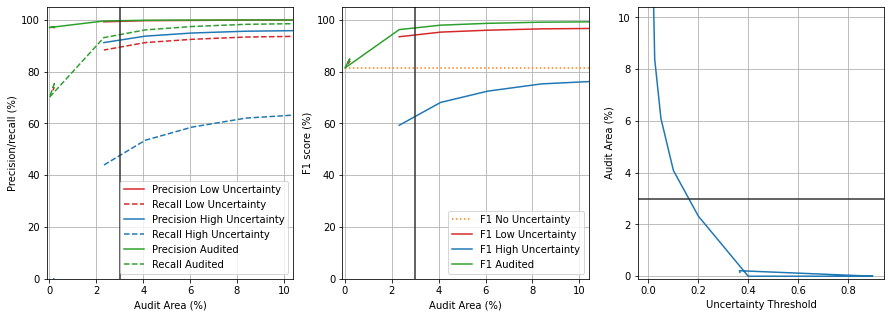

In [115]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
trainer.plotUncertaintyAA()

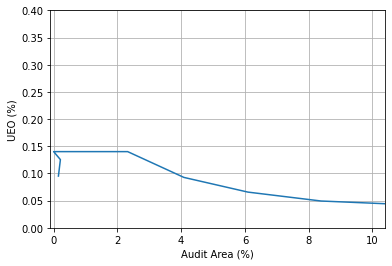

In [116]:
trainer.plotUEO()

In [117]:
trainer.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| bounds: (0.0015, 0.3663794801235199)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.1408715596097929
threshold 0.1408715596097929


ic| label_current_deforestation_test_classified_incorrect.shape: (1731223,)
    predicted_test_classified_incorrect.shape: (1731223,)
ic| TP_H + FN_H + FP_H + TN_H: 1731223
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1731223
    len(label_mask_current_deforestation_test): 54181542


[0.99638856 0.9014511  0.4532224  0.03195227 0.92699274 0.49824498
 0.11264581]
0.22700792051372695
threshold 0.22700792051372695


ic| label_current_deforestation_test_classified_incorrect.shape: (1080850,)
    predicted_test_classified_incorrect.shape: (1080850,)
ic| TP_H + FN_H + FP_H + TN_H: 1080850
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1080850
    len(label_mask_current_deforestation_test): 54181542


[0.98993754 0.87587673 0.5506934  0.01994868 0.9061887  0.40475403
 0.15334792]
0.08763636090393405
threshold 0.08763636090393405


ic| label_current_deforestation_test_classified_incorrect.shape: (2408642,)
    predicted_test_classified_incorrect.shape: (2408642,)
ic| TP_H + FN_H + FP_H + TN_H: 2408642
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2408642
    len(label_mask_current_deforestation_test): 54181542


[0.99740559 0.91503173 0.3824479  0.04445503 0.94047595 0.54724363
 0.08628524]
0.16401704072386725
threshold 0.16401704072386725


ic| label_current_deforestation_test_classified_incorrect.shape: (1524977,)
    predicted_test_classified_incorrect.shape: (1524977,)
ic| TP_H + FN_H + FP_H + TN_H: 1524977
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1524977
    len(label_mask_current_deforestation_test): 54181542


[0.99532297 0.894645   0.48028875 0.02814569 0.92112098 0.47646623
 0.1234496 ]
0.15380089255642282
threshold 0.15380089255642282


ic| label_current_deforestation_test_classified_incorrect.shape: (1612283,)
    predicted_test_classified_incorrect.shape: (1612283,)
ic| TP_H + FN_H + FP_H + TN_H: 1612283
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1612283
    len(label_mask_current_deforestation_test): 54181542


[0.99587365 0.89756428 0.46845633 0.02975705 0.92367296 0.48633761
 0.1186485 ]
0.15261323206260033
threshold 0.15261323206260033


ic| label_current_deforestation_test_classified_incorrect.shape: (1622804,)
    predicted_test_classified_incorrect.shape: (1622804,)
ic| TP_H + FN_H + FP_H + TN_H: 1622804
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1622804
    len(label_mask_current_deforestation_test): 54181542


[0.99593282 0.89791353 0.46703633 0.02995123 0.92397795 0.48748826
 0.11809649]
0.14812831227039625
threshold 0.14812831227039625


ic| label_current_deforestation_test_classified_incorrect.shape: (1663294,)
    predicted_test_classified_incorrect.shape: (1663294,)
ic| TP_H + FN_H + FP_H + TN_H: 1663294
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1663294
    len(label_mask_current_deforestation_test): 54181542


[0.99614219 0.89933969 0.46181528 0.03069854 0.92508876 0.49157645
 0.11603176]
0.15170328989037926
threshold 0.15170328989037926


ic| label_current_deforestation_test_classified_incorrect.shape: (1630952,)
    predicted_test_classified_incorrect.shape: (1630952,)
ic| TP_H + FN_H + FP_H + TN_H: 1630952
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1630952
    len(label_mask_current_deforestation_test): 54181542


[0.99597785 0.89825079 0.46593624 0.03010162 0.92421363 0.4883357
 0.11769204]
0.15243317335660386
threshold 0.15243317335660386


ic| label_current_deforestation_test_classified_incorrect.shape: (1624381,)
    predicted_test_classified_incorrect.shape: (1624381,)
ic| TP_H + FN_H + FP_H + TN_H: 1624381
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1624381
    len(label_mask_current_deforestation_test): 54181542


[0.99593669 0.8979763  0.46682171 0.02998034 0.92403249 0.48765567
 0.1180162 ]
0.15225472592389733
threshold 0.15225472592389733


ic| label_current_deforestation_test_classified_incorrect.shape: (1626010,)
    predicted_test_classified_incorrect.shape: (1626010,)
ic| TP_H + FN_H + FP_H + TN_H: 1626010
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1626010
    len(label_mask_current_deforestation_test): 54181542


[0.99594619 0.89802949 0.4665936  0.0300104  0.92408115 0.4878414
 0.11793171]
0.1522880615155332
threshold 0.1522880615155332


ic| label_current_deforestation_test_classified_incorrect.shape: (1625728,)
    predicted_test_classified_incorrect.shape: (1625728,)
ic| TP_H + FN_H + FP_H + TN_H: 1625728
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1625728
    len(label_mask_current_deforestation_test): 54181542


[0.99594654 0.89800944 0.46663409 0.0300052  0.92406903 0.48781468
 0.11794361]
0.15232585578480035
threshold 0.15232585578480035


ic| label_current_deforestation_test_classified_incorrect.shape: (1625363,)
    predicted_test_classified_incorrect.shape: (1625363,)
ic| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542


[0.99594121 0.89800472 0.46668133 0.02999846 0.92406472 0.48777253
 0.11796408]
0.1523668474496392
threshold 0.1523668474496392


ic| label_current_deforestation_test_classified_incorrect.shape: (1624995,)
    predicted_test_classified_incorrect.shape: (1624995,)
ic| TP_H + FN_H + FP_H + TN_H: 1624995
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1624995
    len(label_mask_current_deforestation_test): 54181542
ic| self.threshold_optimal: 0.15232585578480035


[0.99594172 0.89798346 0.46673938 0.02999167 0.92404733 0.48772981
 0.11798075]


In [118]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.15232585578480035


ic| label_current_deforestation_test_classified_incorrect.shape: (1625363,)
    predicted_test_classified_incorrect.shape: (1625363,)
ic| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1625363
    len(label_mask_current_deforestation_test): 54181542


[0.99594121 0.89800472 0.46668133 0.02999846 0.92406472 0.48777253
 0.11796408]
threshold 0.15232585578480035
(54181542,) (54181542,)


ic| self.m_optimal: {'AA': array([0.02999846]),
                     'UEO': array([0.11796408]),
                     'f1': 81.41,
                     'f1_H': array([0.63850615]),
                     'f1_L': array([0.9444408]),
                     'precision_H': array([0.92406472]),
                     'precision_L': array([0.99594121]),
                     'recall_H': array([0.48777253]),
                     'recall_L': array([0.89800472]),
                     'recall_Ltotal': array([0.46668133])}
ic| self.m_audited_optimal: {'f1': array([0.97182636]),
                             'precision': array([0.99799569]),
                             'recall': array([0.94699438])}


cm_audited [[53439287     1409]
 [   39269   701577]]
[0.99799569 0.94699438]


{'metrics': {'precision_L': array([0.99594121]),
  'recall_L': array([0.89800472]),
  'recall_Ltotal': array([0.46668133]),
  'AA': array([0.02999846]),
  'precision_H': array([0.92406472]),
  'recall_H': array([0.48777253]),
  'UEO': array([0.11796408]),
  'f1_L': array([0.9444408]),
  'f1_H': array([0.63850615]),
  'f1': 81.41},
 'metrics_audited': {'precision': array([0.99799569]),
  'recall': array([0.94699438]),
  'f1': array([0.97182636])},
 'exp': 123}